In [1]:
import os
import dill
import bilby
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from tqdm import tqdm

from util import plot_single_evolution, violinplot, dpi_key_to_label

%load_ext autoreload
%autoreload 2

plt.style.use("./tgr-hybrid-sampling.mplstyle")

In [2]:
dphi2_posterior = pd.read_hdf("./150914_hybrid.hdf5", key="d_phi_2")
dphi2_overlap0_posterior = pd.read_hdf("./150914_hybrid.hdf5", key="d_phi_2_no_overlap")

In [3]:
res_dphi2 = bilby.core.result.Result(
        posterior = dphi2_posterior,
        search_parameter_keys = list( dphi2_posterior.columns )
    )

res_dphi2_overlap0 = bilby.core.result.Result(
    posterior = dphi2_overlap0_posterior,
    search_parameter_keys = list( dphi2_overlap0_posterior.columns )
)

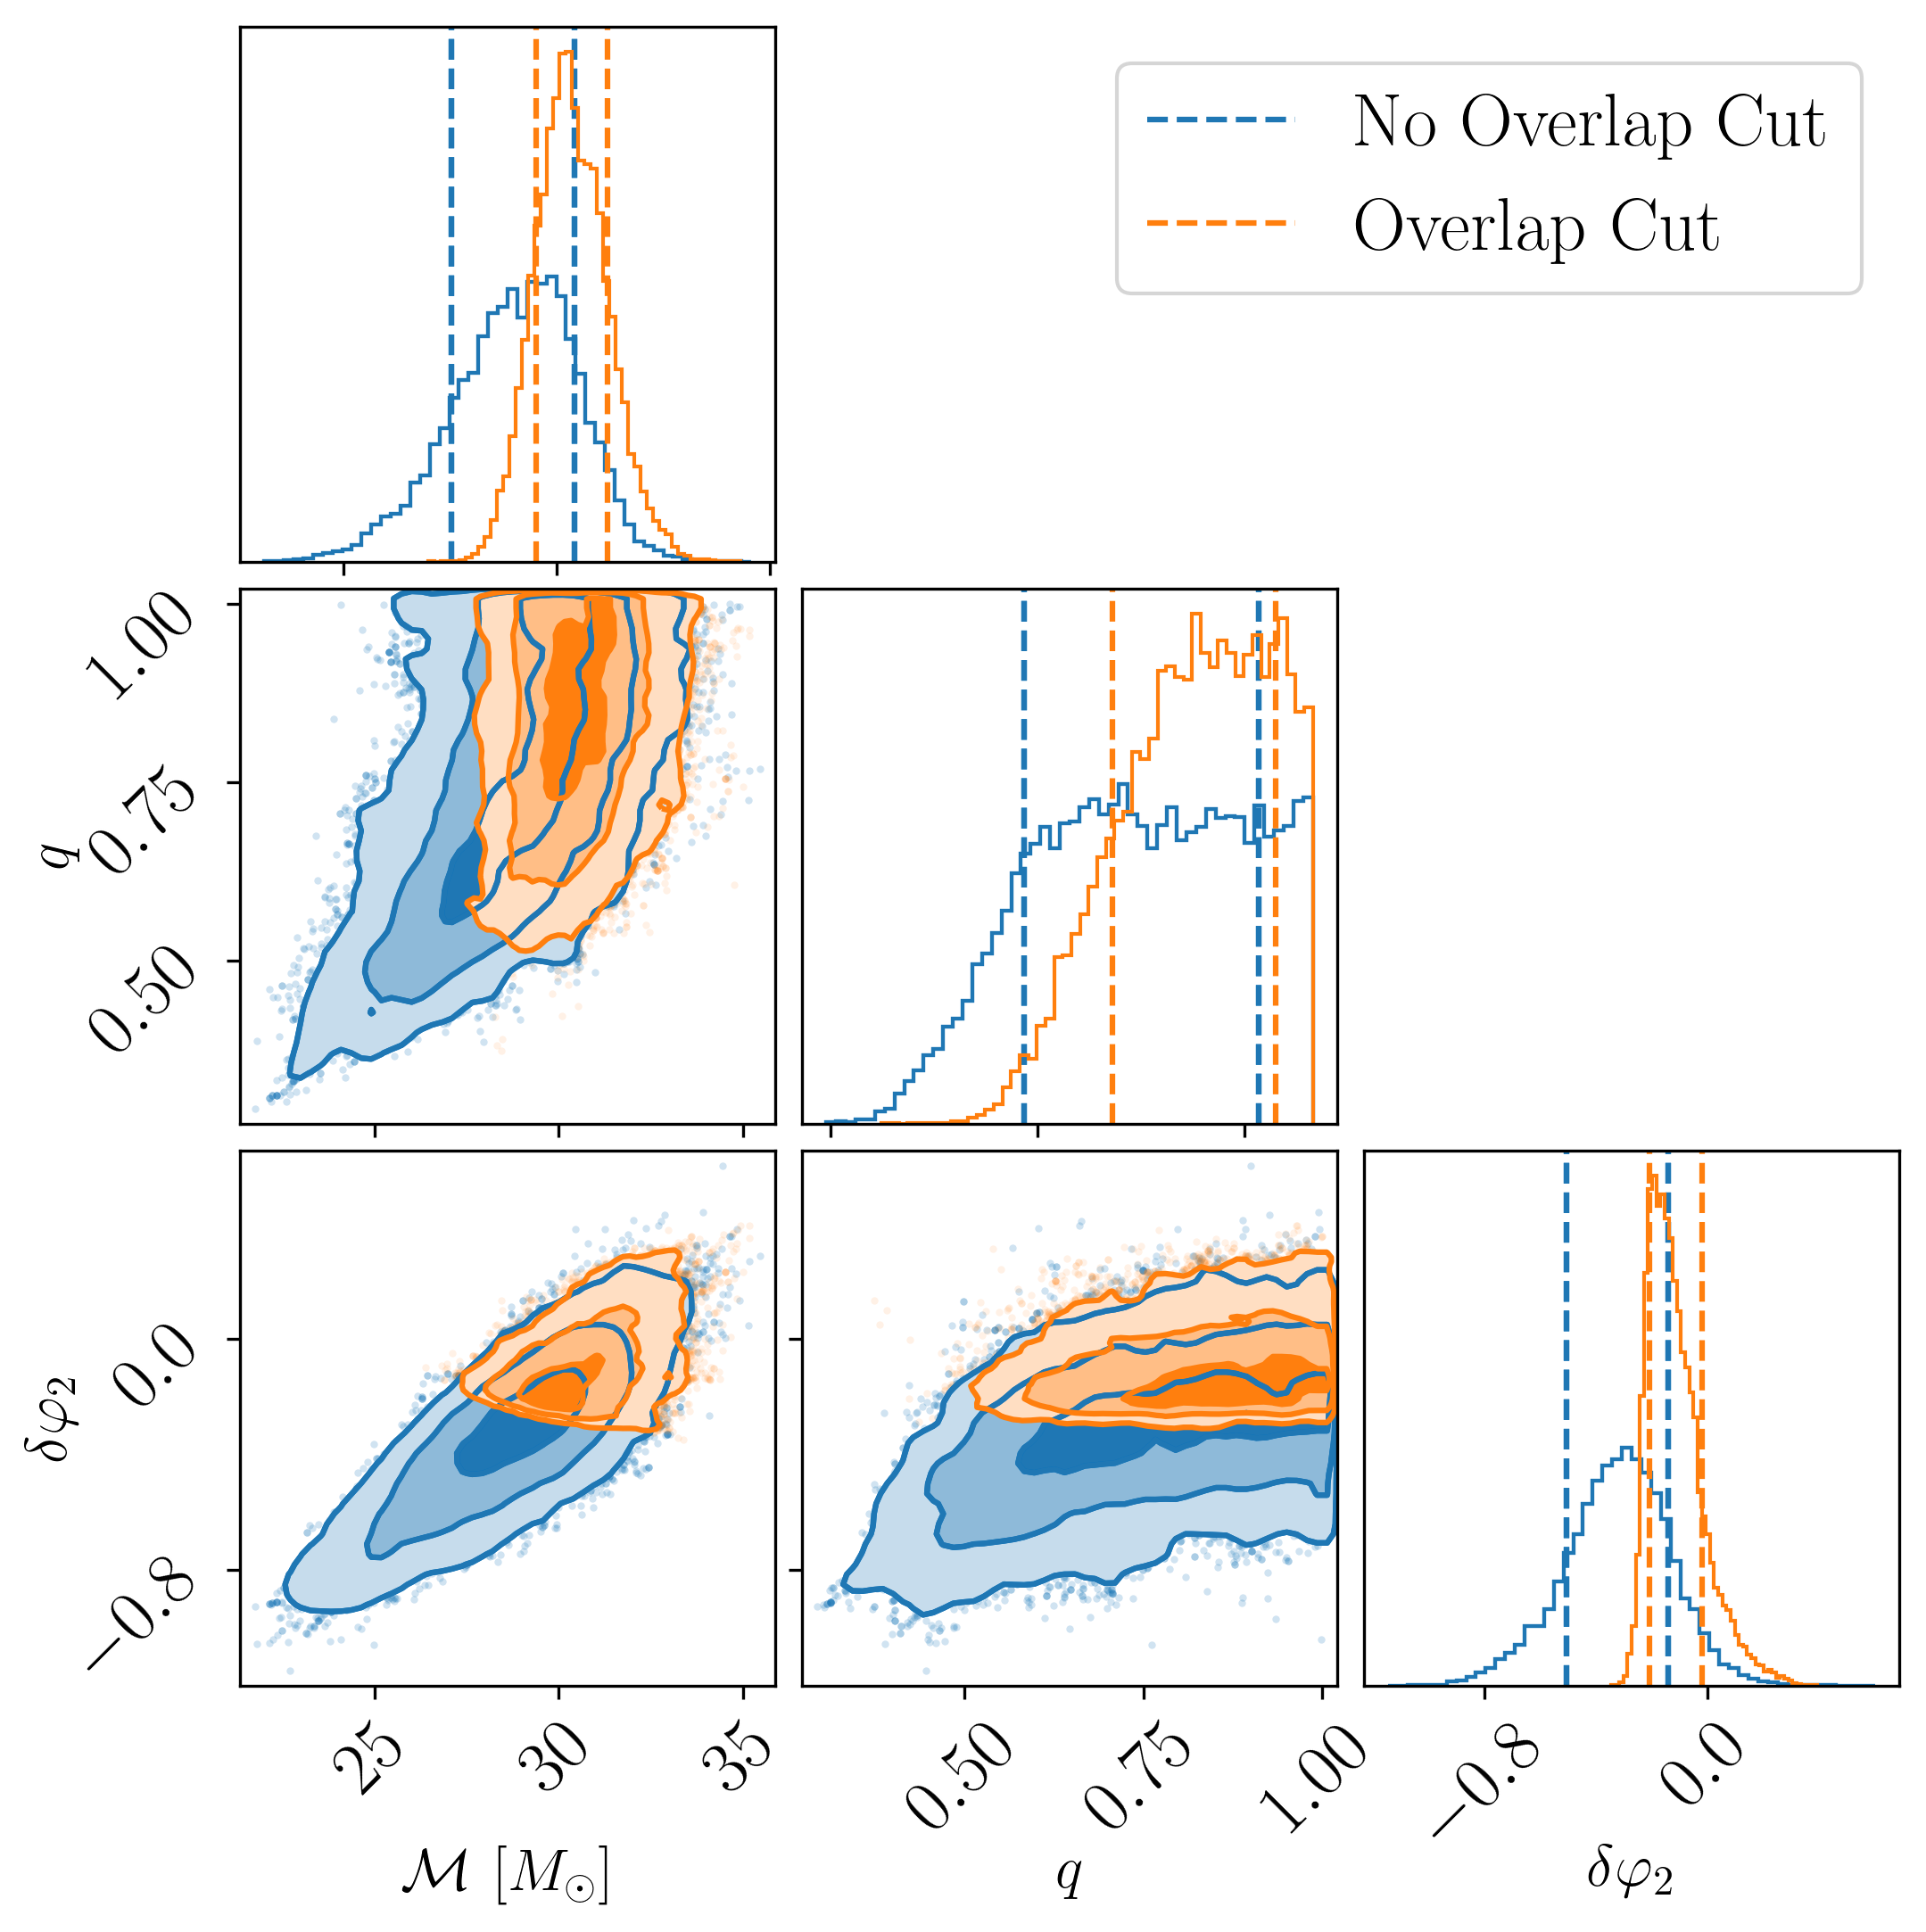

In [4]:
with plt.rc_context({'lines.linestyle' : '--'}):
    fig = bilby.core.result.plot_multiple(
        [res_dphi2_overlap0, res_dphi2],
        labels = ["No Overlap Cut", "Overlap Cut"],
        titles = False,
        truth_color = "black",
        parameters = ["chirp_mass", "mass_ratio", "d_phi_2"],
        corner_labels = [
            r"$\mathcal{M}$ [$M_{\odot}$]", 
            r"$q$",
            dpi_key_to_label("d_phi_2")
        ]
    )

fig.savefig("./gw150914_dphi2_overlap-comparison.pdf")